# Steady-State Point Mass Lap Time Simulation #

Aragon Speed Circuit Layout

General approach to model developement will be as follows:
* Previous Excel implementations simply used a binary driver command and a somewhat arbitrarily defined positive/negative acceleration. Previous implementation was also for a simple oval geometry. Now, want to use the real circuit utilized by the MotoStudent competition and begin to build a more realistic code.
* Plan is to implement a classical steady-state solver with the bike represented as a point mass. These solvers are typically distance based rather than time based, and this will be no exception.
* The "tire model" in this case will be a simple traction ellipse, which helps develop the GG plot. This plot determines the maximum lateral and longitudinal accelerations that are physically possible purely from a tyre peformance perspective. 
* Overall process will include defining each corner apex and then finding the maximum lateral velocity at each of these apexes.
* Largest process difference with this code will be the forward and backwards pass. Once each apex sped is defined, we need to find the optimal way to traverse from one apex to the next. By calculating a forward pass, we simulate the effects of absolute acceleration. By calculating a backwards pass, we then simulate the effects of absolute braking. Then, we find the intersection point of these behaviors to find the optimal velocity profile. 

In [1]:
# Import Statements 
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import argrelextrema

### Track Coordinates Generation ###

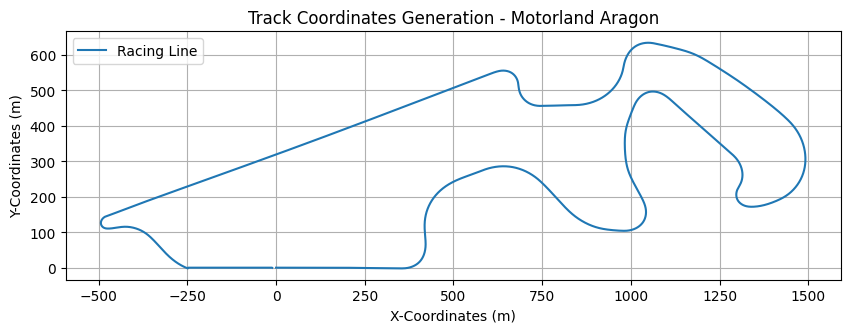

In [2]:
# Loading Data from .json File 
with open('Aragon_CircuitA.json', 'r') as file:
    data = json.load(file)

cLap = np.array(data["config"]["cLap"]) # Positive curvature corresponds to turning left 
sLap = np.array(data["config"]["sLap"])

# Initializing Arrays
N = len(cLap)
theta_vals = np.zeros(N)
x_vals = np.zeros(N)
y_vals = np.zeros(N)

# Calculating Coordinates 
for i in range(1, N):
    
    # Data collection was not accurate for this portion, manually setting y=0
    for j in range(5050,N):
        cLap[j] = 0
        y_vals[j] = 0

    delta_s = sLap[i] - sLap[i-1]
    theta = theta_vals[i-1] + (cLap[i-1] * delta_s)
    x = x_vals[i-1] + np.cos(theta_vals[i-1]) * delta_s
    y = y_vals[i-1] + np.sin(theta_vals[i-1]) * delta_s
    theta_vals[i] = theta
    x_vals[i] = x
    y_vals[i] = y

# Plotting Result 
plt.figure(figsize=(10, 10))
plt.plot(x_vals, y_vals, label="Racing Line")
plt.title("Track Coordinates Generation - Motorland Aragon")
plt.xlabel("X-Coordinates (m)")
plt.ylabel("Y-Coordinates (m)")
plt.grid(True)
plt.legend()
plt.gca().set_aspect('equal')
plt.show()


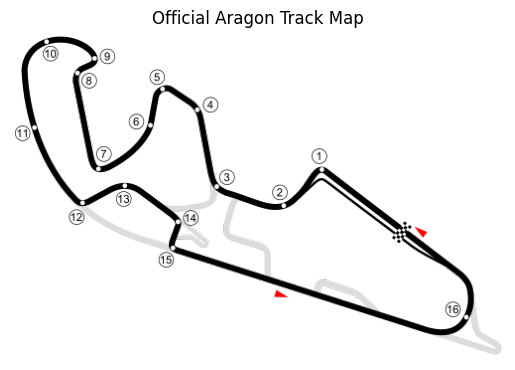

In [3]:
img = Image.open("Motorland_Aragon_TrackMap.png")  # Replace with your actual file path
plt.imshow(img)
plt.axis('off') 
plt.title("Official Aragon Track Map")
plt.show()

### Defining Vehicle and Environmental Parameters ###

In [4]:
mass = 130 # kg: example weight taken from UniBo Motorsports
g = 9.81 # m/s^2

### Building Friction Ellipse (Super Simplified Tire Model) ###

$$ (\frac{a_x}{a_{x,max}})^2 + (\frac{a_y}{a_{y,max}})^2 = 1 $$

In [5]:
mu_x = 1.25 # Longitudinal Direction
mu_y = 1.35 # Lateral Direction 

ax_max = mu_x * g # m/s^2
ay_max = mu_y * g # m/s^2

print(f'Max Longitudinal Acceleration: {ax_max:.2f} m/s²')
print(f'Max Lateral Acceleration: {ay_max:.2f} m/s²')

Max Longitudinal Acceleration: 12.26 m/s²
Max Lateral Acceleration: 13.24 m/s²


### Building GG-Plot ###

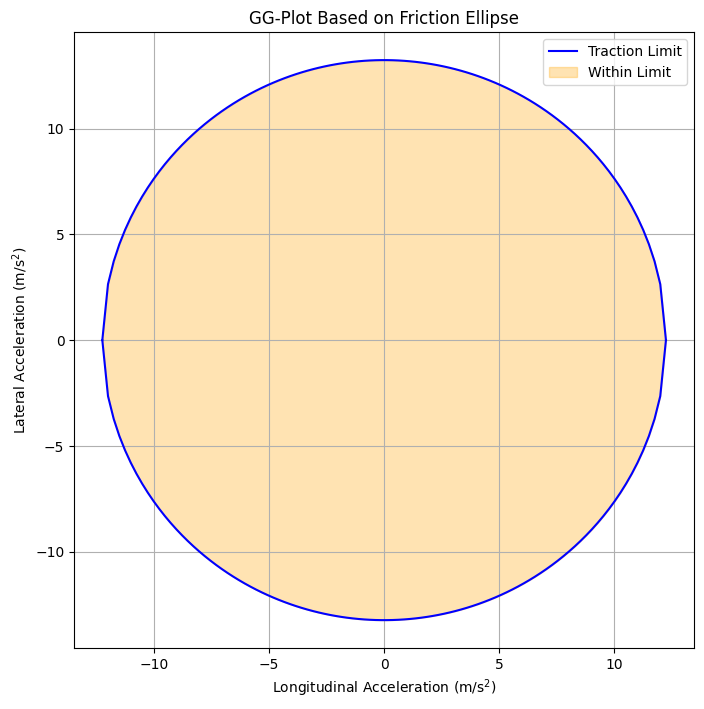

In [6]:
ax_vals = np.linspace(-ax_max, ax_max, 100)
ay_upper = ay_max * np.sqrt(1-(ax_vals/ax_max)**2)
ay_lower = -1 * ay_upper

plt.figure(figsize=(8, 8))
plt.plot(ax_vals, ay_upper, '-b', label= 'Traction Limit')
plt.plot(ax_vals, ay_lower, '-b')
plt.title('GG-Plot Based on Friction Ellipse')
plt.xlabel(r'Longitudinal Acceleration ($\mathrm{m/s^2}$)')
plt.ylabel(r'Lateral Acceleration ($\mathrm{m/s^2}$)')
plt.fill_between(ax_vals, ay_lower, ay_upper, color='orange', alpha=0.3, label='Within Limit')
plt.legend()
plt.grid(True)

### Computing Cornering Limits ###

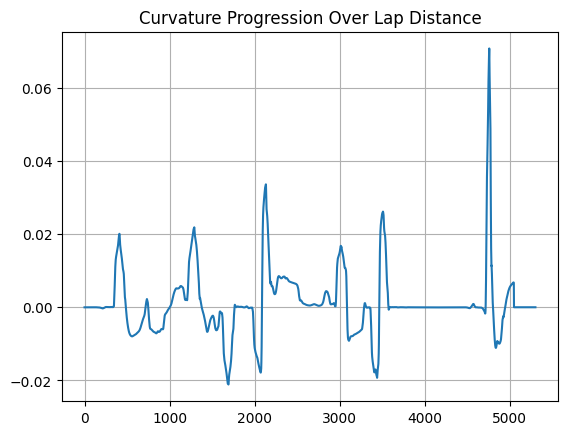

In [7]:
plt.plot(sLap, cLap)
plt.title('Curvature Progression Over Lap Distance')
plt.grid(True)

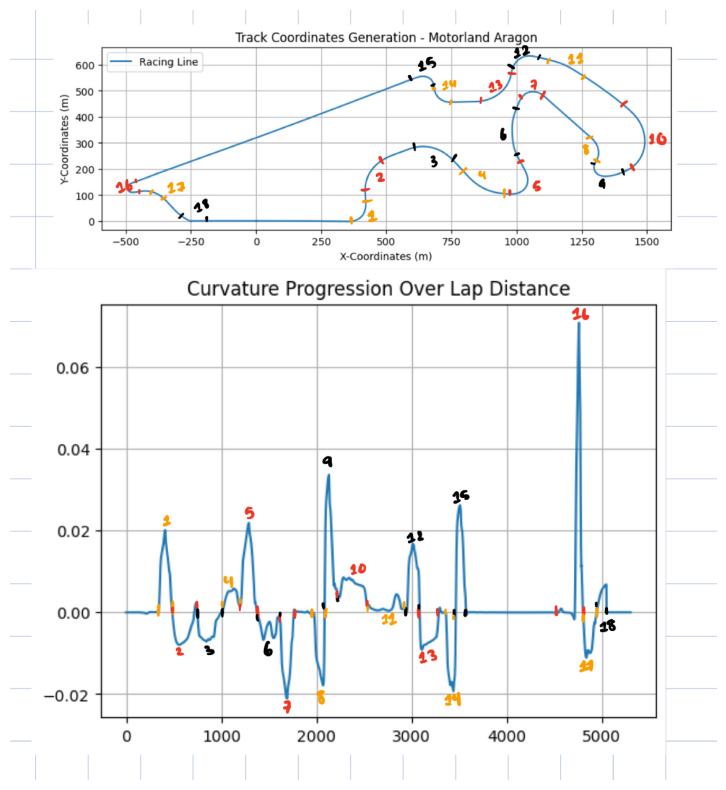

In [8]:
img = Image.open("CornerDiagram.jpeg")
plt.figure(figsize=(14, 10)) 
plt.imshow(img)
plt.axis('off')
plt.show()

#### Corner 1 ####

Maximum curvature = 0.02008 at (X, Y) = (404.98, 17.03)
Minimum curvature = 0.00031 at (X, Y) = (345.04, -2.00)


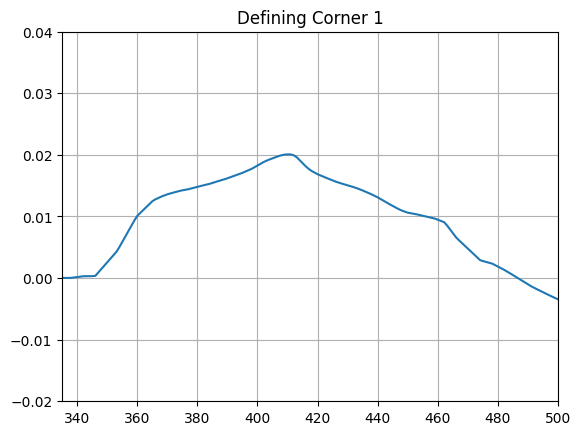

In [9]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 1')
plt.xlim(335, 500)  
plt.ylim(-0.02, 0.04)
plt.grid(True)

start_idx = 345
end_idx   = 485

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner1_sLap = sLap_slice
corner1_cLap = cLap_slice
corner1_xvals = xvals_slice
corner1_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex1 = max_idx
apex1_glob_idx = start_idx + apex1

#### Corner 2 ####

Maximum curvature = 0.00225 at (X, Y) = (557.79, 264.91)
Minimum curvature = -0.00795 at (X, Y) = (425.58, 161.28)


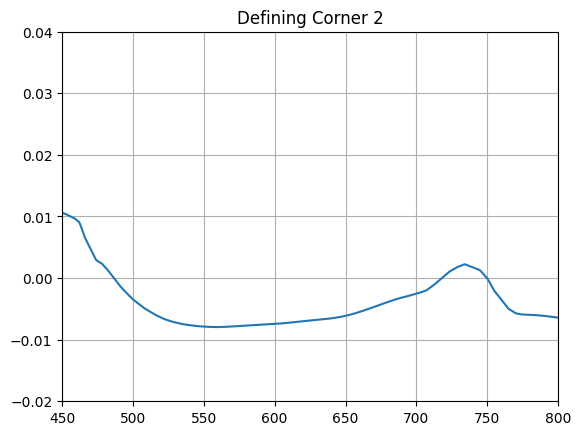

In [10]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 2')
plt.xlim(450, 800)  
plt.ylim(-0.02, 0.04)
plt.grid(True)

start_idx = 486
end_idx   = 735

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner2_sLap = sLap_slice
corner2_cLap = cLap_slice
corner2_xvals = xvals_slice
corner2_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex2 = min_idx
apex2_glob_idx = start_idx + apex2

#### Corner 3 ####

Maximum curvature = 0.00207 at (X, Y) = (559.66, 265.61)
Minimum curvature = -0.00713 at (X, Y) = (664.48, 283.90)


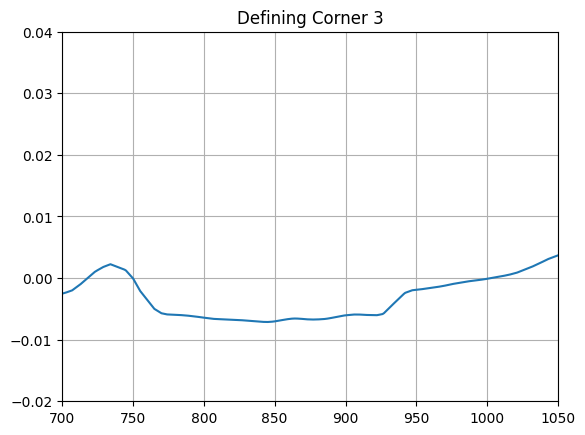

In [11]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 3')
plt.xlim(700, 1050)  
plt.ylim(-0.02, 0.04)
plt.grid(True)

start_idx = 736
end_idx   = 1000

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner3_sLap = sLap_slice
corner3_cLap = cLap_slice
corner3_xvals = xvals_slice
corner3_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex3 = min_idx
apex3_glob_idx = start_idx + apex3

#### Corner 4 ####

Maximum curvature = 0.00582 at (X, Y) = (895.88, 116.09)
Minimum curvature = -0.00007 at (X, Y) = (790.60, 196.28)


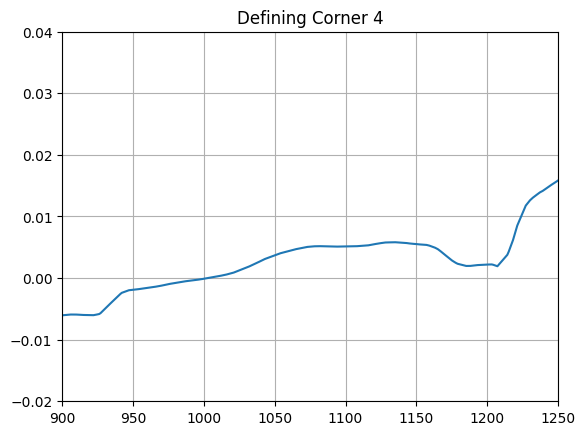

In [12]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 4')
plt.xlim(900, 1250)  
plt.ylim(-0.02, 0.04)
plt.grid(True)

start_idx = 1001
end_idx   = 1210

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner4_sLap = sLap_slice
corner4_cLap = cLap_slice
corner4_xvals = xvals_slice
corner4_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex4 = max_idx
apex4_glob_idx = start_idx + apex4

#### Corner 5 ####

Maximum curvature = 0.02185 at (X, Y) = (1038.56, 135.81)
Minimum curvature = 0.00224 at (X, Y) = (1030.17, 197.92)


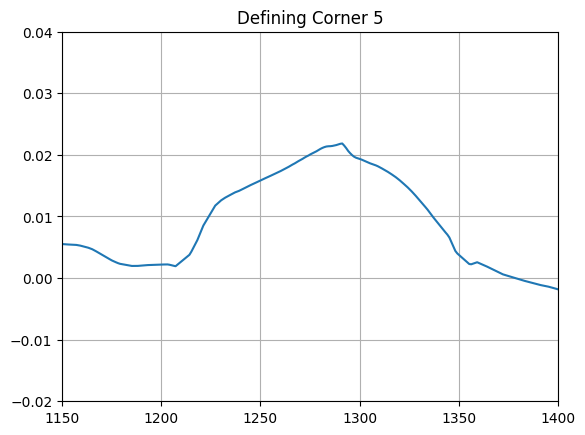

In [13]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 5')
plt.xlim(1150, 1400)  
plt.ylim(-0.02, 0.04)
plt.grid(True)

start_idx = 1211
end_idx   = 1360

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner5_sLap = sLap_slice
corner5_cLap = cLap_slice
corner5_xvals = xvals_slice
corner5_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex5 = max_idx
apex5_glob_idx = start_idx + apex5

#### Corner 6 ####

Maximum curvature = 0.00229 at (X, Y) = (1027.87, 202.36)
Minimum curvature = -0.00673 at (X, Y) = (991.64, 276.88)


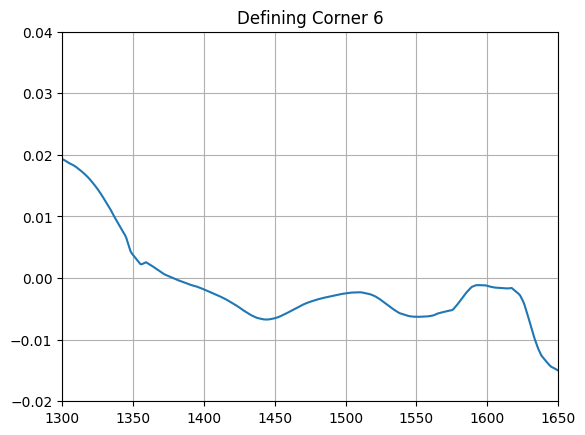

In [14]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 6')
plt.xlim(1300, 1650)  
plt.ylim(-0.02, 0.04)
plt.grid(True)

start_idx = 1361
end_idx   = 1630

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner6_sLap = sLap_slice
corner6_cLap = cLap_slice
corner6_xvals = xvals_slice
corner6_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex6 = min_idx
apex6_glob_idx = start_idx + apex6

#### Corner 7 ####

Maximum curvature = -0.00640 at (X, Y) = (1107.41, 477.21)
Minimum curvature = -0.02110 at (X, Y) = (1056.39, 496.21)


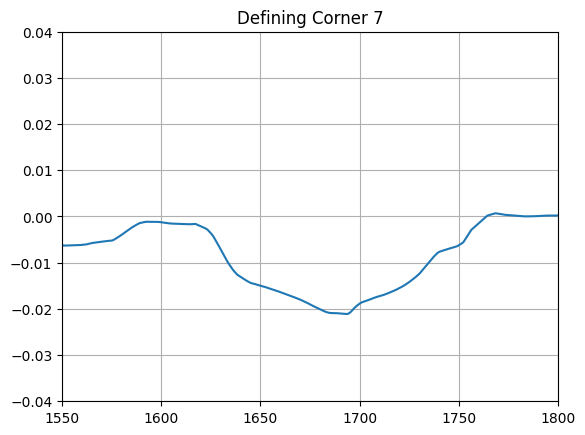

In [15]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 7')
plt.xlim(1550, 1800)  
plt.ylim(-0.04, 0.04)
plt.grid(True)

start_idx = 1631
end_idx   = 1750

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner7_sLap = sLap_slice
corner7_cLap = cLap_slice
corner7_xvals = xvals_slice
corner7_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex7 = min_idx
apex7_glob_idx = start_idx + apex7

#### Corner 8 ####

Maximum curvature = -0.00109 at (X, Y) = (1280.54, 324.24)
Minimum curvature = -0.01786 at (X, Y) = (1311.91, 243.65)


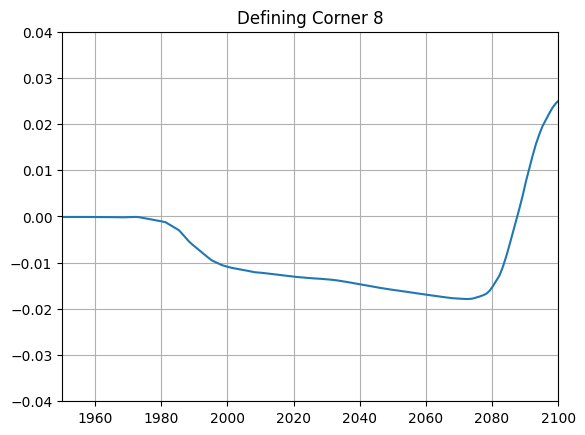

In [16]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 8')
plt.xlim(1950, 2100)  
plt.ylim(-0.04, 0.04)
plt.grid(True)

start_idx = 1980
end_idx   = 2085

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner8_sLap = sLap_slice
corner8_cLap = cLap_slice
corner8_xvals = xvals_slice
corner8_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex8 = min_idx - 30
apex8_glob_idx = start_idx + apex8

#### Corner 9 ####

Maximum curvature = 0.03359 at (X, Y) = (1303.27, 187.12)
Minimum curvature = -0.00351 at (X, Y) = (1306.09, 230.95)


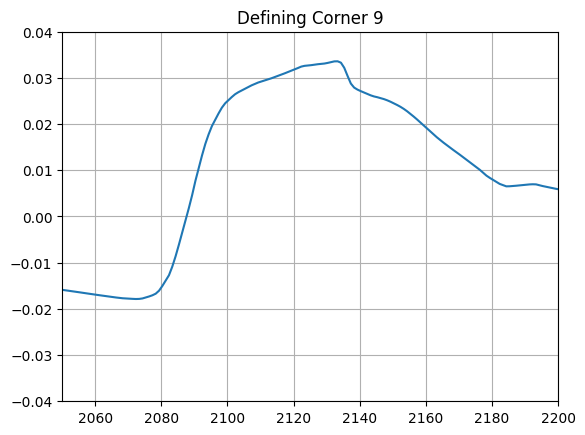

In [17]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 9')
plt.xlim(2050, 2200)  
plt.ylim(-0.04, 0.04)
plt.grid(True)

start_idx = 2086
end_idx   = 2200

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner9_sLap = sLap_slice
corner9_cLap = cLap_slice
corner9_xvals = xvals_slice
corner9_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex9 = max_idx
apex9_glob_idx = start_idx + apex9

#### Corner 10 ####

Maximum curvature = 0.00851 at (X, Y) = (1443.40, 206.71)
Minimum curvature = 0.00165 at (X, Y) = (1420.55, 436.66)


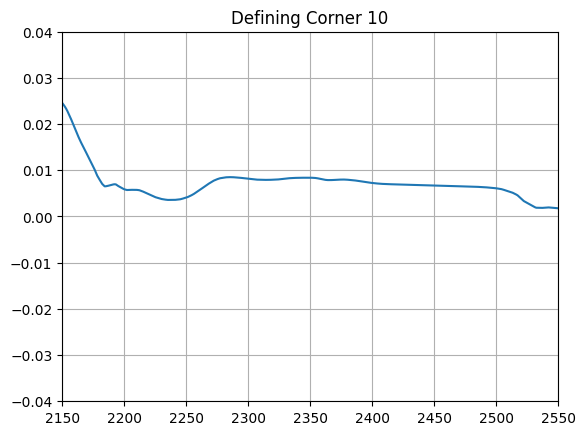

In [18]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 10')
plt.xlim(2150, 2550)  
plt.ylim(-0.04, 0.04)
plt.grid(True)

start_idx = 2201
end_idx   = 2555

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner10_sLap = sLap_slice
corner10_cLap = cLap_slice
corner10_xvals = xvals_slice
corner10_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex10 = max_idx
apex10_glob_idx = start_idx + apex10

#### Corner 11 ####

In [19]:
# plt.plot(sLap, cLap)
# plt.title('Defining Corner 11')
# plt.xlim(2400, 3000)  
# plt.ylim(-0.04, 0.04)
# plt.grid(True)

# start_idx = 2476
# end_idx   = 2875

# sLap_slice  = sLap[start_idx:end_idx]
# cLap_slice  = cLap[start_idx:end_idx]
# xvals_slice = x_vals[start_idx:end_idx]
# yvals_slice = y_vals[start_idx:end_idx]

# corner11_sLap = sLap_slice
# corner11_cLap = cLap_slice
# corner11_xvals = xvals_slice
# corner11_yvals = yvals_slice

# max_idx = np.argmax(cLap_slice)
# max_val = cLap_slice[max_idx]
# max_x   = xvals_slice[max_idx]
# max_y   = yvals_slice[max_idx]

# min_idx = np.argmin(cLap_slice)
# min_val = cLap_slice[min_idx]
# min_x   = xvals_slice[min_idx]
# min_y   = yvals_slice[min_idx]

# print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
# print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

#### Corner 12 ####

Maximum curvature = 0.01678 at (X, Y) = (1017.57, 626.54)
Minimum curvature = -0.00917 at (X, Y) = (974.02, 544.91)


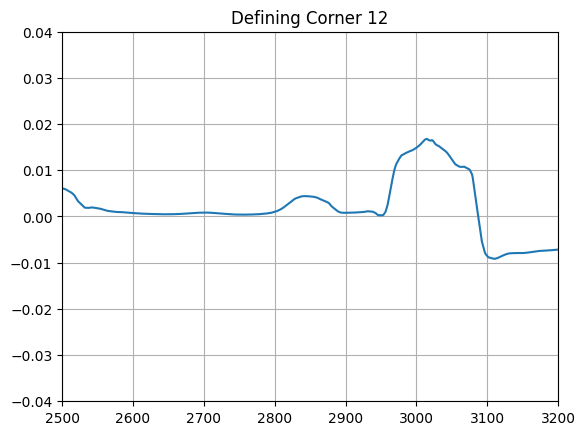

In [20]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 12')
plt.xlim(2500, 3200)  
plt.ylim(-0.04, 0.04)
plt.grid(True)

start_idx = 2800
end_idx   = 3125

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner12_sLap = sLap_slice
corner12_cLap = cLap_slice
corner12_xvals = xvals_slice
corner12_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex12 = max_idx
apex12_glob_idx = start_idx + apex12

#### Corner 13 ####

Maximum curvature = 0.00112 at (X, Y) = (821.07, 457.83)
Minimum curvature = -0.00818 at (X, Y) = (967.60, 530.27)


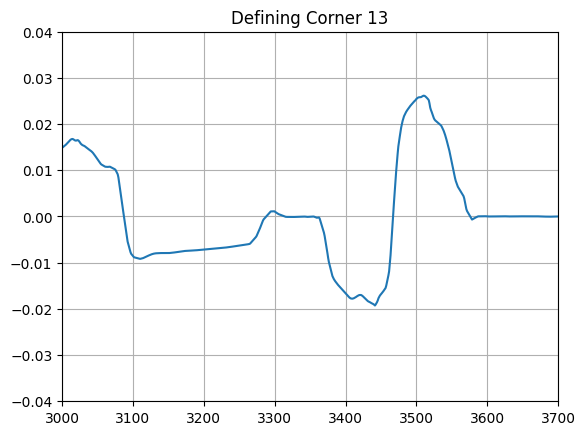

In [21]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 13')
plt.xlim(3000, 3700)  
plt.ylim(-0.04, 0.04)
plt.grid(True)

start_idx = 3126
end_idx   = 3349

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner13_sLap = sLap_slice
corner13_cLap = cLap_slice
corner13_xvals = xvals_slice
corner13_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex13 = min_idx + 75
apex13_glob_idx = start_idx + apex13

#### Corner 14 ####

Maximum curvature = 0.01516 at (X, Y) = (682.68, 518.39)
Minimum curvature = -0.01927 at (X, Y) = (690.30, 486.52)


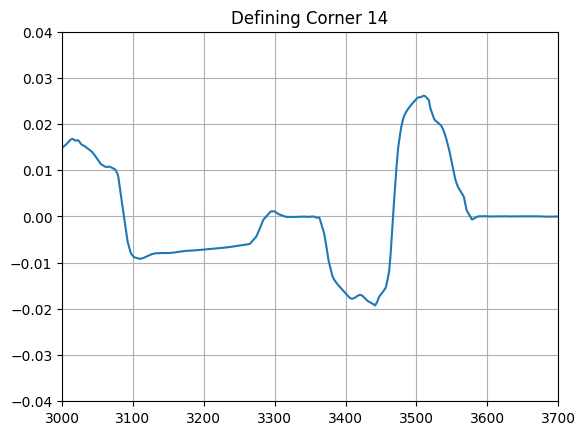

In [22]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 14')
plt.xlim(3000, 3700)  
plt.ylim(-0.04, 0.04)
plt.grid(True)

start_idx = 3350
end_idx   = 3475

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner14_sLap = sLap_slice
corner14_cLap = cLap_slice
corner14_xvals = xvals_slice
corner14_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex14 = min_idx - 20
apex14_glob_idx = start_idx + apex14

#### Corner 15 ####

Maximum curvature = 0.02615 at (X, Y) = (664.87, 548.45)
Minimum curvature = 0.00236 at (X, Y) = (608.25, 548.11)


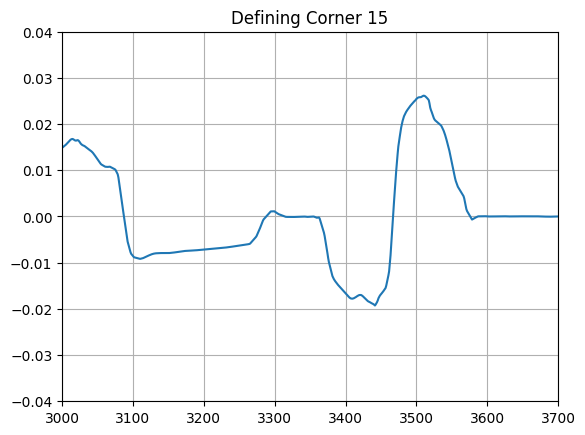

In [23]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 15')
plt.xlim(3000, 3700)  
plt.ylim(-0.04, 0.04)
plt.grid(True)

start_idx = 3476
end_idx   = 3570

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner15_sLap = sLap_slice
corner15_cLap = cLap_slice
corner15_xvals = xvals_slice
corner15_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex15 = max_idx
apex15_glob_idx = start_idx + apex15

#### Corner 16 ####

Maximum curvature = 0.07072 at (X, Y) = (-492.56, 120.14)
Minimum curvature = -0.00168 at (X, Y) = (-448.53, 113.04)


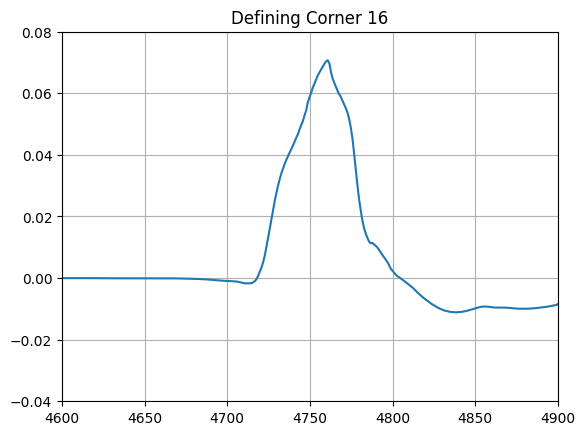

In [24]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 16')
plt.xlim(4600, 4900)  
plt.ylim(-0.04, 0.08)
plt.grid(True)

start_idx = 4720
end_idx   = 4809

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner16_sLap = sLap_slice
corner16_cLap = cLap_slice
corner16_xvals = xvals_slice
corner16_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex16 = max_idx
apex16_glob_idx = start_idx + apex16

#### Corner 17 ####

Maximum curvature = 0.00010 at (X, Y) = (-327.91, 58.92)
Minimum curvature = -0.01111 at (X, Y) = (-418.67, 115.18)


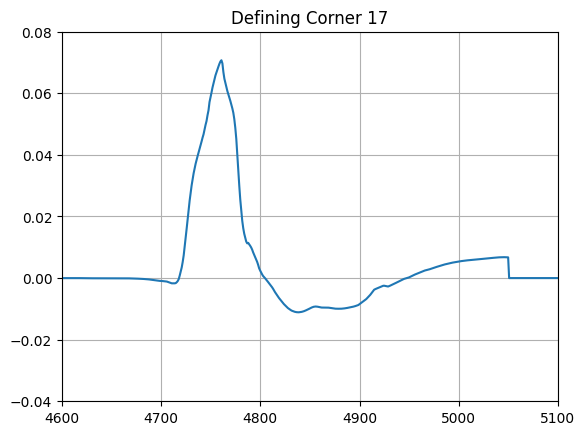

In [25]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 17')
plt.xlim(4600, 5100)  
plt.ylim(-0.04, 0.08)
plt.grid(True)

start_idx = 4810
end_idx   = 4949

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner17_sLap = sLap_slice
corner17_cLap = cLap_slice
corner17_xvals = xvals_slice
corner17_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex17 = max_idx - 70
apex17_glob_idx = start_idx + apex17

#### Corner 18 ####

Maximum curvature = 0.00678 at (X, Y) = (-252.45, -0.65)
Minimum curvature = 0.00000 at (X, Y) = (-247.80, 0.00)


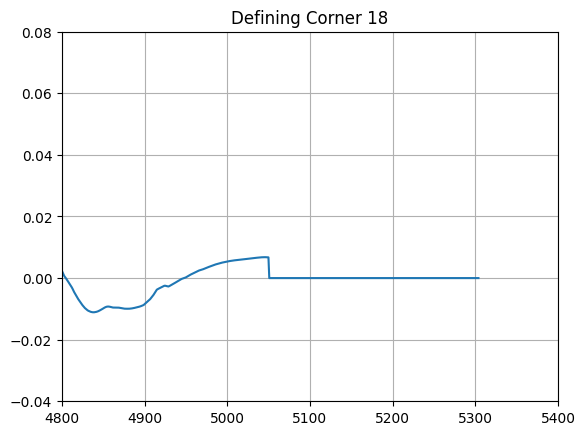

In [26]:
plt.plot(sLap, cLap)
plt.title('Defining Corner 18')
plt.xlim(4800, 5400)  
plt.ylim(-0.04, 0.08)
plt.grid(True)

start_idx = 4950
end_idx   = 5150

sLap_slice  = sLap[start_idx:end_idx]
cLap_slice  = cLap[start_idx:end_idx]
xvals_slice = x_vals[start_idx:end_idx]
yvals_slice = y_vals[start_idx:end_idx]

corner18_sLap = sLap_slice
corner18_cLap = cLap_slice
corner18_xvals = xvals_slice
corner18_yvals = yvals_slice

max_idx = np.argmax(cLap_slice)
max_val = cLap_slice[max_idx]
max_x   = xvals_slice[max_idx]
max_y   = yvals_slice[max_idx]

min_idx = np.argmin(cLap_slice)
min_val = cLap_slice[min_idx]
min_x   = xvals_slice[min_idx]
min_y   = yvals_slice[min_idx]

print(f"Maximum curvature = {max_val:.5f} at (X, Y) = ({max_x:.2f}, {max_y:.2f})")
print(f"Minimum curvature = {min_val:.5f} at (X, Y) = ({min_x:.2f}, {min_y:.2f})")

apex18 = max_idx 
apex18_glob_idx = start_idx + apex18

#### Creating Composite Image (Sanity Check) ####

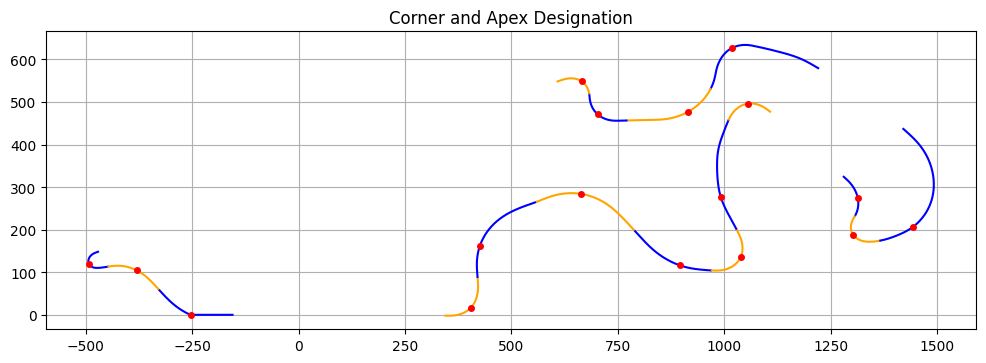

In [27]:
plt.figure(figsize=(12, 12))

plt.plot(corner1_xvals, corner1_yvals, 'orange')
plt.plot(corner1_xvals[apex1], corner1_yvals[apex1], 'ro', markersize=4, label='Corner 1 Apex')

plt.plot(corner2_xvals, corner2_yvals, 'blue')
plt.plot(corner2_xvals[apex2], corner2_yvals[apex2], 'ro', markersize=4, label='Corner 2 Apex')

plt.plot(corner3_xvals, corner3_yvals, 'orange')
plt.plot(corner3_xvals[apex3], corner3_yvals[apex3], 'ro', markersize=4, label='Corner 3 Apex')

plt.plot(corner4_xvals, corner4_yvals, 'blue')
plt.plot(corner4_xvals[apex4], corner4_yvals[apex4], 'ro', markersize=4, label='Corner 4 Apex')

plt.plot(corner5_xvals, corner5_yvals, 'orange')
plt.plot(corner5_xvals[apex5], corner5_yvals[apex5], 'ro', markersize=4, label='Corner 5 Apex')

plt.plot(corner6_xvals, corner6_yvals, 'blue')
plt.plot(corner6_xvals[apex6], corner6_yvals[apex6], 'ro', markersize=4, label='Corner 6 Apex')

plt.plot(corner7_xvals, corner7_yvals, 'orange')
plt.plot(corner7_xvals[apex7], corner7_yvals[apex7], 'ro', markersize=4, label='Corner 7 Apex')

plt.plot(corner8_xvals, corner8_yvals, 'blue')
plt.plot(corner8_xvals[apex8], corner8_yvals[apex8], 'ro', markersize=4, label='Corner 8 Apex')

plt.plot(corner9_xvals, corner9_yvals, 'orange')
plt.plot(corner9_xvals[apex9], corner9_yvals[apex9], 'ro', markersize=4, label='Corner 9 Apex')

plt.plot(corner10_xvals, corner10_yvals, 'blue')
plt.plot(corner10_xvals[apex10], corner10_yvals[apex10], 'ro', markersize=4, label='Corner 10 Apex')

# plt.plot(corner11_xvals, corner11_yvals, 'orange')
# plt.plot(corner11_xvals[apex11], corner11_yvals[apex11], 'ro', markersize=4, label='Corner 11 Apex')

plt.plot(corner12_xvals, corner12_yvals, 'blue')
plt.plot(corner12_xvals[apex12], corner12_yvals[apex12], 'ro', markersize=4, label='Corner 12 Apex')

plt.plot(corner13_xvals, corner13_yvals, 'orange')
plt.plot(corner13_xvals[apex13], corner13_yvals[apex13], 'ro', markersize=4, label='Corner 13 Apex')

plt.plot(corner14_xvals, corner14_yvals, 'blue')
plt.plot(corner14_xvals[apex14], corner14_yvals[apex14], 'ro', markersize=4, label='Corner 14 Apex')

plt.plot(corner15_xvals, corner15_yvals, 'orange')
plt.plot(corner15_xvals[apex15], corner15_yvals[apex15], 'ro', markersize=4, label='Corner 15 Apex')

plt.plot(corner16_xvals, corner16_yvals, 'blue')
plt.plot(corner16_xvals[apex16], corner16_yvals[apex16], 'ro', markersize=4, label='Corner 16 Apex')

plt.plot(corner17_xvals, corner17_yvals, 'orange')
plt.plot(corner17_xvals[apex17], corner17_yvals[apex17], 'ro', markersize=4, label='Corner 17 Apex')

plt.plot(corner18_xvals, corner18_yvals, 'blue')
plt.plot(corner18_xvals[apex18], corner18_yvals[apex18], 'ro', markersize=4, label='Corner 18 Apex')

plt.gca().set_aspect('equal', adjustable='box')
plt.title('Corner and Apex Designation')
plt.grid(True)

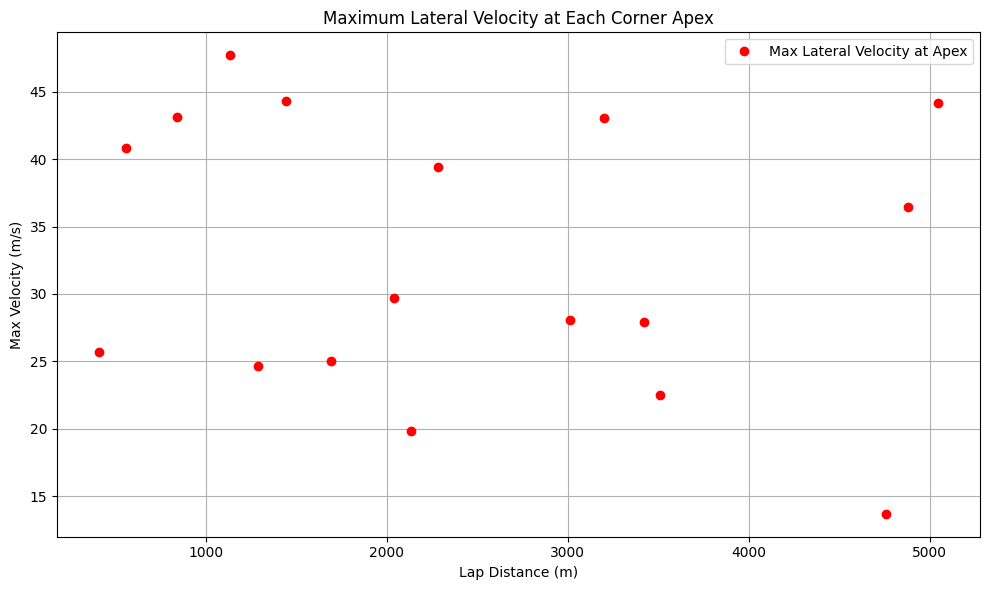

In [28]:
R_a1  = 1 / abs(corner1_cLap[apex1])
lat_vel_max_a1  = np.sqrt(ay_max * R_a1)

R_a2  = 1 / abs(corner2_cLap[apex2])
lat_vel_max_a2  = np.sqrt(ay_max * R_a2)

R_a3  = 1 / abs(corner3_cLap[apex3])
lat_vel_max_a3  = np.sqrt(ay_max * R_a3)

R_a4  = 1 / abs(corner4_cLap[apex4])
lat_vel_max_a4  = np.sqrt(ay_max * R_a4)

R_a5  = 1 / abs(corner5_cLap[apex5])
lat_vel_max_a5  = np.sqrt(ay_max * R_a5)

R_a6  = 1 / abs(corner6_cLap[apex6])
lat_vel_max_a6  = np.sqrt(ay_max * R_a6)

R_a7  = 1 / abs(corner7_cLap[apex7])
lat_vel_max_a7  = np.sqrt(ay_max * R_a7)

R_a8  = 1 / abs(corner8_cLap[apex8])
lat_vel_max_a8  = np.sqrt(ay_max * R_a8)

R_a9  = 1 / abs(corner9_cLap[apex9])
lat_vel_max_a9  = np.sqrt(ay_max * R_a9)

R_a10 = 1 / abs(corner10_cLap[apex10])
lat_vel_max_a10 = np.sqrt(ay_max * R_a10)

# Problem: since T11 has low curvature, is causing a large R and inaccurate speed calc
# Solution will be to extend T10 and T12 segmentation and treat T11 as a straight 
# R_a11 = 1 / abs(corner11_cLap[apex11])
# lat_vel_max_a11 = np.sqrt(ay_max * R_a11)

R_a12 = 1 / abs(corner12_cLap[apex12])
lat_vel_max_a12 = np.sqrt(ay_max * R_a12)

R_a13 = 1 / abs(corner13_cLap[apex13])
lat_vel_max_a13 = np.sqrt(ay_max * R_a13)

R_a14 = 1 / abs(corner14_cLap[apex14])
lat_vel_max_a14 = np.sqrt(ay_max * R_a14)

R_a15 = 1 / abs(corner15_cLap[apex15])
lat_vel_max_a15 = np.sqrt(ay_max * R_a15)

R_a16 = 1 / abs(corner16_cLap[apex16])
lat_vel_max_a16 = np.sqrt(ay_max * R_a16)

R_a17 = 1 / abs(corner17_cLap[apex17])
lat_vel_max_a17 = np.sqrt(ay_max * R_a17)

R_a18 = 1 / abs(corner18_cLap[apex18])
lat_vel_max_a18 = np.sqrt(ay_max * R_a18)

lat_vels = np.array([
    lat_vel_max_a1, 
    lat_vel_max_a2, 
    lat_vel_max_a3, 
    lat_vel_max_a4, 
    lat_vel_max_a5, 
    lat_vel_max_a6, 
    lat_vel_max_a7, 
    lat_vel_max_a8, 
    lat_vel_max_a9, 
    lat_vel_max_a10, 
    #lat_vel_max_a11, 
    lat_vel_max_a12, 
    lat_vel_max_a13, 
    lat_vel_max_a14, 
    lat_vel_max_a15, 
    lat_vel_max_a16, 
    lat_vel_max_a17, 
    lat_vel_max_a18])

xgrid_vals = np.array([
    corner1_sLap[apex1],
    corner2_sLap[apex2],
    corner3_sLap[apex3],
    corner4_sLap[apex4],
    corner5_sLap[apex5],
    corner6_sLap[apex6],
    corner7_sLap[apex7],
    corner8_sLap[apex8],
    corner9_sLap[apex9],
    corner10_sLap[apex10],
    #corner11_sLap[apex11],
    corner12_sLap[apex12],
    corner13_sLap[apex13],
    corner14_sLap[apex14],
    corner15_sLap[apex15],
    corner16_sLap[apex16],
    corner17_sLap[apex17],
    corner18_sLap[apex18]
])

plt.figure(figsize=(10, 6))
plt.plot(xgrid_vals, lat_vels, 'ro', markersize=6, label='Max Lateral Velocity at Apex')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Max Velocity (m/s)')
plt.title('Maximum Lateral Velocity at Each Corner Apex')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


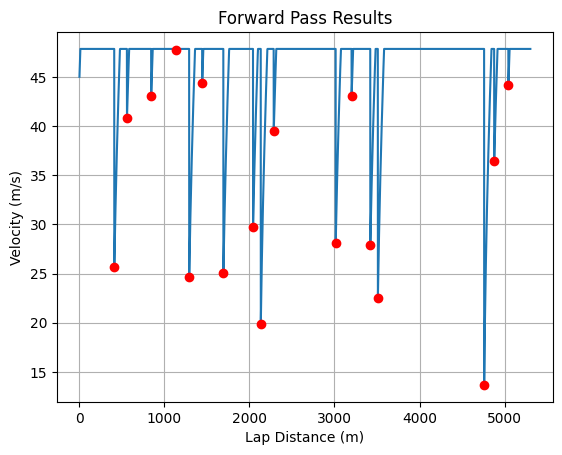

In [29]:
# Computing Forward Pass

apex_idxs = np.array([0, # First line is not an apex, just establishing start/finish
                      apex1_glob_idx, 
                      apex2_glob_idx, 
                      apex3_glob_idx,
                      apex4_glob_idx,
                      apex5_glob_idx,
                      apex6_glob_idx,
                      apex7_glob_idx,
                      apex8_glob_idx,
                      apex9_glob_idx,
                      apex10_glob_idx,
                      apex12_glob_idx,
                      apex13_glob_idx,
                      apex14_glob_idx,
                      apex15_glob_idx,
                      apex16_glob_idx,
                      apex17_glob_idx,
                      apex18_glob_idx,
                      N-1]) # Last line is not an apex, just establishing start/finish

int_for_vel = 45 # m/s: initial velocity that we are giving the bike

apex_idx_vels = np.array([int_for_vel, # Establishing that the lap will start at the same initial speed
                          lat_vel_max_a1,
                          lat_vel_max_a2,
                          lat_vel_max_a3,
                          lat_vel_max_a4,
                          lat_vel_max_a5,
                          lat_vel_max_a6,
                          lat_vel_max_a7,
                          lat_vel_max_a8,
                          lat_vel_max_a9,
                          lat_vel_max_a10,
                          lat_vel_max_a12,
                          lat_vel_max_a13,
                          lat_vel_max_a14,
                          lat_vel_max_a15,
                          lat_vel_max_a16,
                          lat_vel_max_a17,
                          lat_vel_max_a18,
                          int_for_vel]) # Establishing that the lap will finish at the same initial speed

M = len(apex_idxs)

for_vel = np.zeros(N)
back_vel = np.zeros(N)

max_ther_vel = 47.8333 # m/s: max theoretical velocity of the bike 
for_vel[0] = int_for_vel
for_vel[1] = np.sqrt((for_vel[0])**2 + 2*ax_max*(sLap[1]-sLap[0]))

# Forward pass for acceleration values 
for i in range(1, N-1):
    ds = sLap[i+1] - sLap[i]
    for j in range(0, M):
        if(i < apex_idxs[j]):
            for_vel[i+1] = np.sqrt((for_vel[i])**2 + 2 * ax_max * ds)
            if(for_vel[i+1] > max_ther_vel):
                for_vel[i+1] = max_ther_vel
        elif(i == apex_idxs[j]):
            for_vel[i] = min(for_vel[i], apex_idx_vels[j])      # enforce velocity at apex
            for_vel[i+1] = min(for_vel[i+1], apex_idx_vels[j])  # limit next step too


plt.plot(sLap, for_vel)
plt.plot(xgrid_vals, lat_vels, 'ro')
plt.title('Forward Pass Results')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

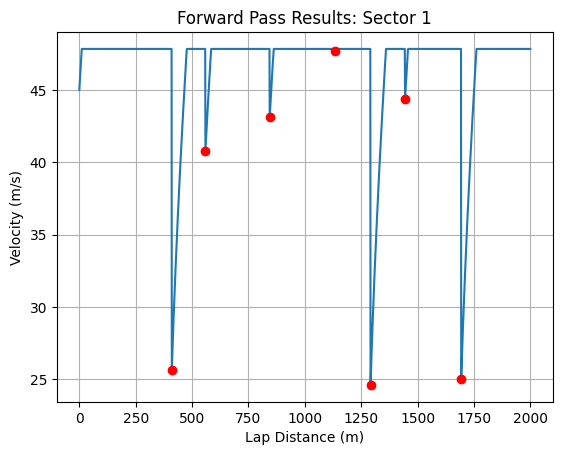

In [30]:
sector1 = sLap[0:2000]

plt.plot(sector1, for_vel[0:2000])
plt.plot(xgrid_vals[0:7], lat_vels[0:7], 'ro')
plt.title('Forward Pass Results: Sector 1')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

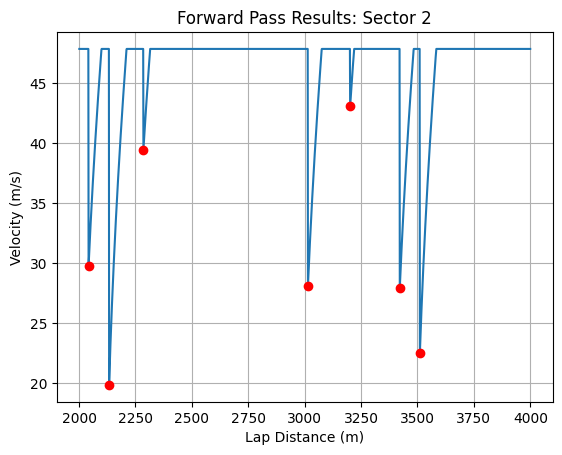

In [31]:
sector2 = sLap[2001:4000]

plt.plot(sector2, for_vel[2001:4000])
plt.plot(xgrid_vals[7:14], lat_vels[7:14], 'ro')
plt.title('Forward Pass Results: Sector 2')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

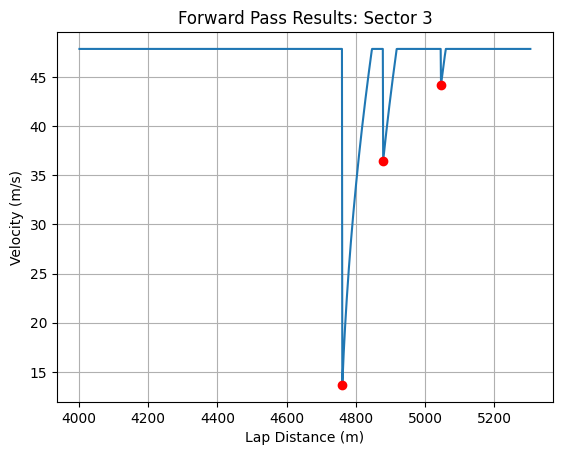

In [32]:
sector3 = sLap[4001:N]

plt.plot(sector3, for_vel[4001:N])
plt.plot(xgrid_vals[14:18], lat_vels[14:18], 'ro')
plt.title('Forward Pass Results: Sector 3')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

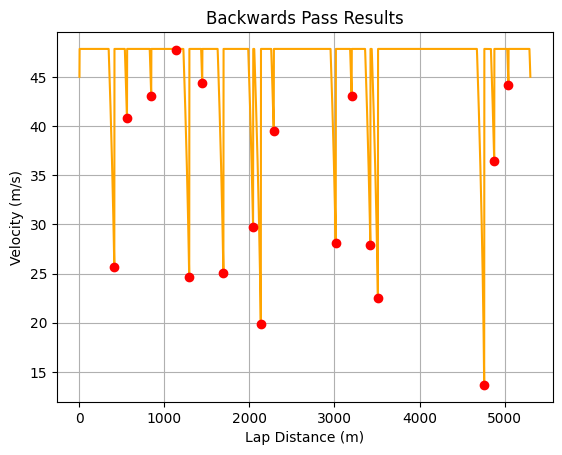

In [33]:
# Computing Backwards Pass 

apex_idxs = np.array([0, # First line is not an apex, just establishing start/finish
                      apex1_glob_idx, 
                      apex2_glob_idx, 
                      apex3_glob_idx,
                      apex4_glob_idx,
                      apex5_glob_idx,
                      apex6_glob_idx,
                      apex7_glob_idx,
                      apex8_glob_idx,
                      apex9_glob_idx,
                      apex10_glob_idx,
                      apex12_glob_idx,
                      apex13_glob_idx,
                      apex14_glob_idx,
                      apex15_glob_idx,
                      apex16_glob_idx,
                      apex17_glob_idx,
                      apex18_glob_idx,
                      N-1]) # Last line is not an apex, just establishing start/finish

int_for_vel = 45 # m/s: initial velocity that we are giving the bike

apex_idx_vels = np.array([int_for_vel, # Establishing that the lap will start at the same initial speed
                          lat_vel_max_a1,
                          lat_vel_max_a2,
                          lat_vel_max_a3,
                          lat_vel_max_a4,
                          lat_vel_max_a5,
                          lat_vel_max_a6,
                          lat_vel_max_a7,
                          lat_vel_max_a8,
                          lat_vel_max_a9,
                          lat_vel_max_a10,
                          lat_vel_max_a12,
                          lat_vel_max_a13,
                          lat_vel_max_a14,
                          lat_vel_max_a15,
                          lat_vel_max_a16,
                          lat_vel_max_a17,
                          lat_vel_max_a18,
                          int_for_vel]) # Establishing that the lap will finish at the same initial speed

N = len(sLap)
K = len(apex_idxs)

back_vel = np.zeros(N)

# initialise at final apex (finish line)
back_vel[-1] = apex_idx_vels[-1]

# -------------------------------------------------------------------------------
# integrate *segment by segment* :  (apex_k  →  apex_{k-1})
# -------------------------------------------------------------------------------
for k in range(K-1, 0, -1):                      # from last real apex back to the first
    i_end   = apex_idxs[k]       # index of current (down‐track) apex
    v_end   = apex_idx_vels[k]   # its allowed speed
    i_start = apex_idxs[k-1]     # previous (up‐track) apex

    back_vel[i_end] = v_end      # set velocity exactly at the apex

    # integrate backwards to the previous apex
    for i in range(i_end-1, i_start-1, -1):
        ds   = sLap[i+1] - sLap[i]               # positive metres
        v_sq = back_vel[i+1]**2 + 2*ax_max*ds    # brake-limited step
        v    = np.sqrt(v_sq) if v_sq > 0 else 0.0
        v    = min(v, max_ther_vel)              # never exceed theoretical top speed
        back_vel[i] = v

    # finally, **override** the velocity at the previous apex to its lateral limit
    back_vel[i_start] = min(back_vel[i_start], apex_idx_vels[k-1])

plt.plot(sLap, back_vel, 'orange')
plt.plot(xgrid_vals, lat_vels, 'ro')
plt.title('Backwards Pass Results')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

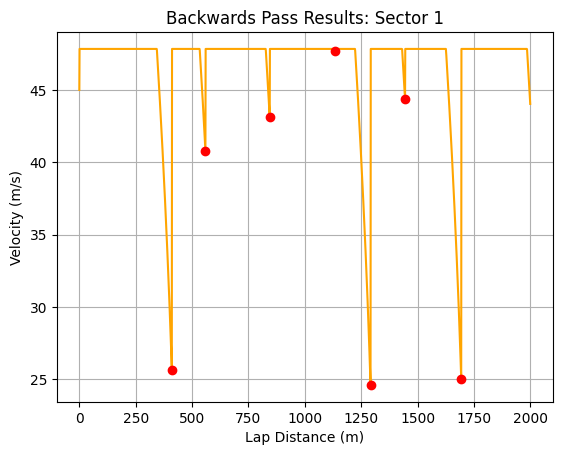

In [34]:
sector1 = sLap[0:2000]

plt.plot(sector1, back_vel[0:2000], 'orange')
plt.plot(xgrid_vals[0:7], lat_vels[0:7], 'ro')
plt.title('Backwards Pass Results: Sector 1')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

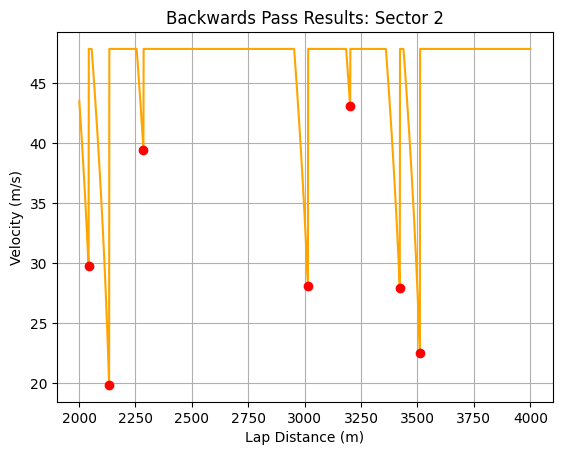

In [35]:
sector2 = sLap[2001:4000]

plt.plot(sector2, back_vel[2001:4000], 'orange')
plt.plot(xgrid_vals[7:14], lat_vels[7:14], 'ro')
plt.title('Backwards Pass Results: Sector 2')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

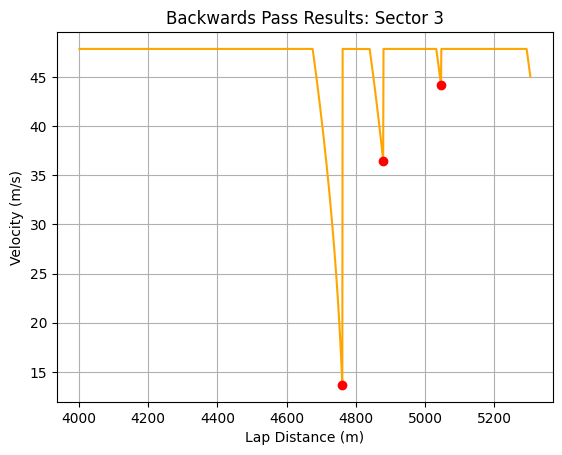

In [36]:
sector3 = sLap[4001:N]

plt.plot(sector3, back_vel[4001:N], 'orange')
plt.plot(xgrid_vals[14:18], lat_vels[14:18], 'ro')
plt.title('Backwards Pass Results: Sector 3')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

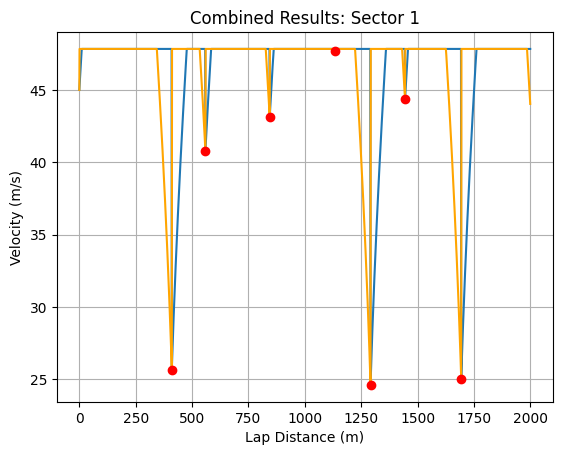

In [37]:
sector1 = sLap[0:2000]

plt.plot(sector1, for_vel[0:2000])
plt.plot(sector1, back_vel[0:2000], 'orange')
plt.plot(xgrid_vals[0:7], lat_vels[0:7], 'ro')
plt.title('Combined Results: Sector 1')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

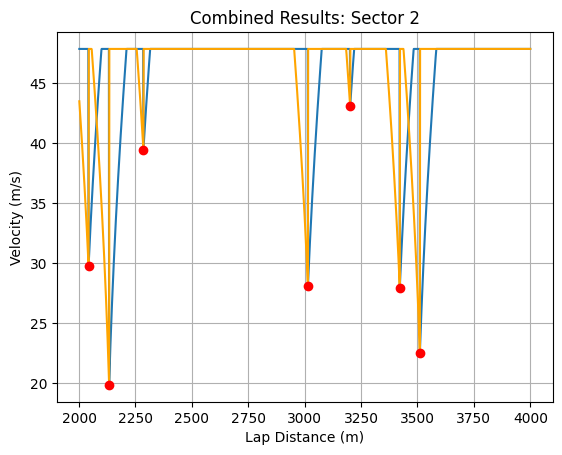

In [38]:
sector2 = sLap[2001:4000]

plt.plot(sector2, for_vel[2001:4000])
plt.plot(sector2, back_vel[2001:4000], 'orange')
plt.plot(xgrid_vals[7:14], lat_vels[7:14], 'ro')
plt.title('Combined Results: Sector 2')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

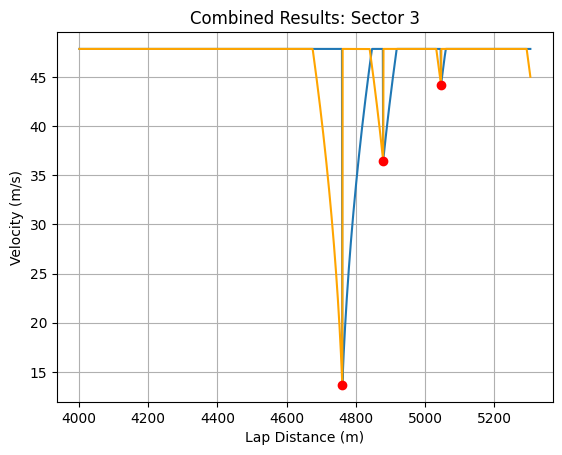

In [39]:
sector3 = sLap[4001:N]

plt.plot(sector3, for_vel[4001:N])
plt.plot(sector3, back_vel[4001:N], 'orange')
plt.plot(xgrid_vals[14:18], lat_vels[14:18], 'ro')
plt.title('Combined Results: Sector 3')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)

### Computing Overall Lap Time ###

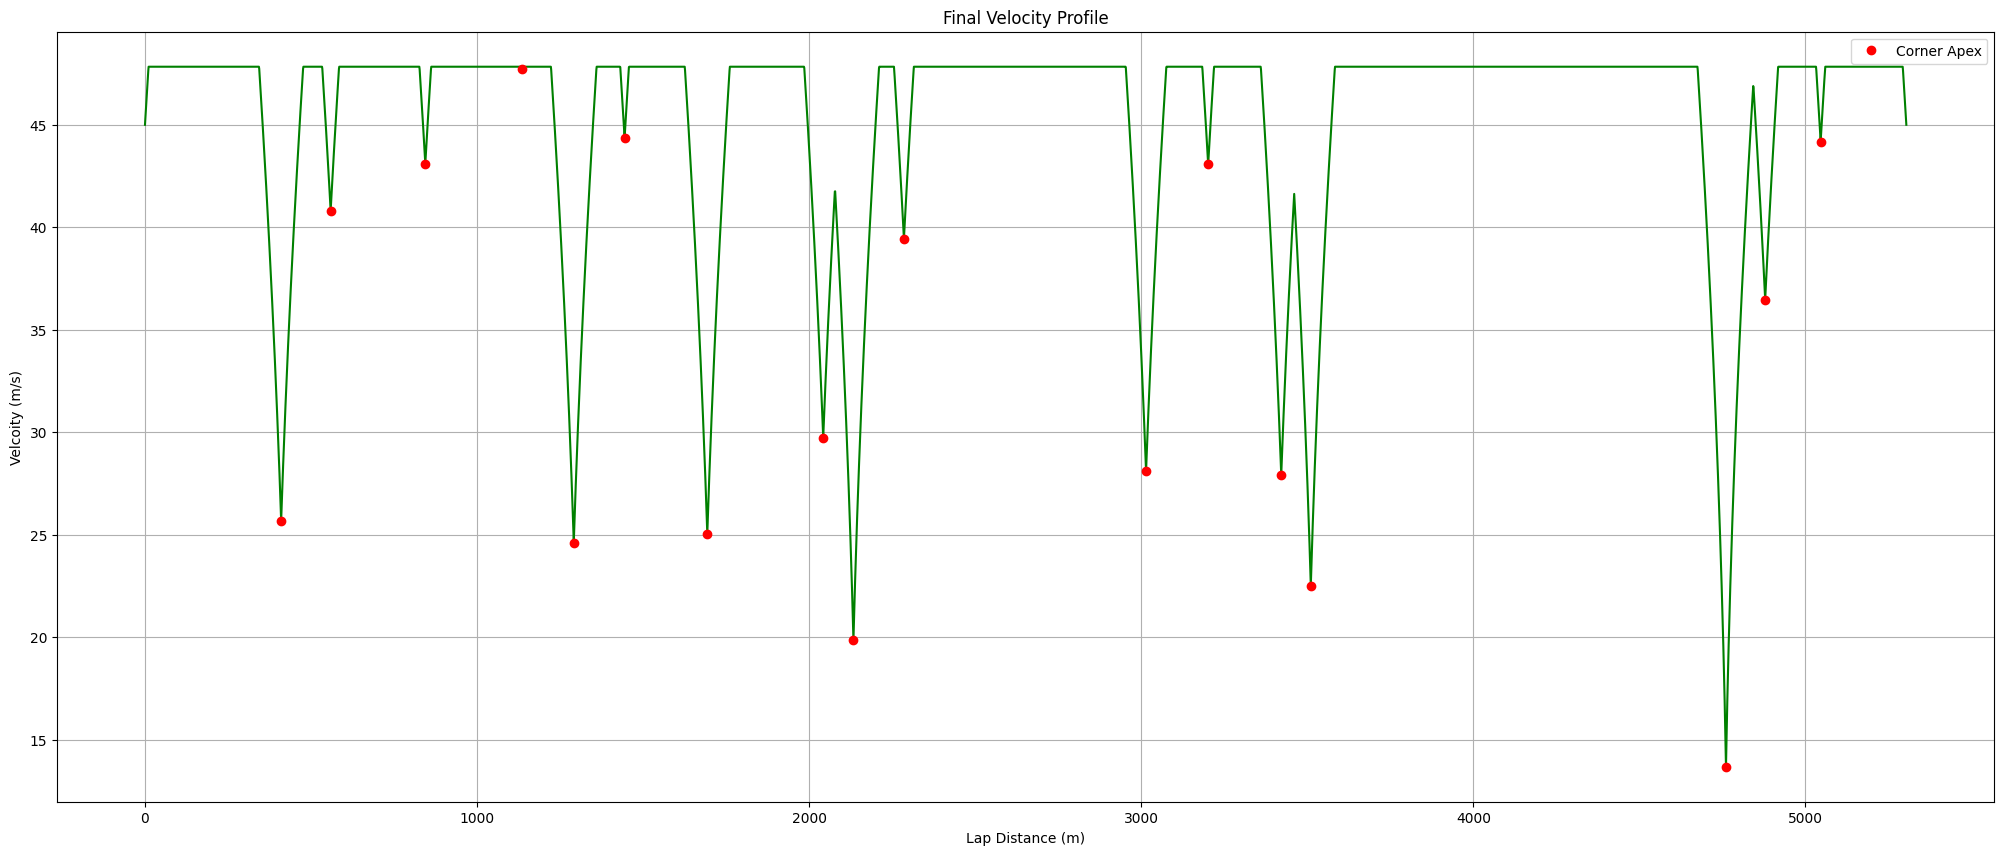

In [40]:
final_vels = np.zeros(N)

for i in range(0,N):
    final_vels[i] = np.minimum(for_vel[i], back_vel[i])

plt.figure(figsize=(25,10))
plt.title('Final Velocity Profile')
plt.xlabel('Lap Distance (m)')
plt.ylabel('Velcoity (m/s)')
plt.plot(sLap, final_vels, 'green')
plt.plot(xgrid_vals, lat_vels, 'ro', label='Corner Apex')
plt.legend()
plt.grid(True)

In [41]:
segment_times = np.zeros(N)

for i in range(0, N-1):
    ds = sLap[i+1] - sLap[i]
    segment_times[i] = ds / final_vels[i]

lap_time = np.sum(segment_times)

print('Lap Time:', lap_time, 'seconds')

Lap Time: 120.26996278632112 seconds
